In [1]:
import numpy as np


In [ ]:
pip install tick

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/mds20_cohortney")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/mds20_cohortney/src/DMHP')

In [5]:

from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process

from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesSumExpKernels, SimuHawkesMulti, \
    HawkesSumExpKern

from tick.hawkes import SimuHawkes, HawkesKernelSumExp
n_nodes = 10  # dimension of the Hawkes process
adjacency = 0.2 * np.ones((n_nodes, n_nodes))
adjacency[0, 1] = 0
decays = 3 * np.ones((n_nodes, n_nodes))
baseline = 0.5 * np.ones(n_nodes)
hawkes = SimuHawkes(baseline=baseline, verbose=False, seed=2398)

run_time = 100
hawkes.end_time = run_time
dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()
timestamps = hawkes.timestamps

In [4]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

from HP import PointProcessStorage, DirichletMixtureModel, EM_clustering
from metrics import consistency, purity
# from data_utils import load_data

In [5]:
def load_data(path, range_start, range_stop, maxlen=-1):
    s = []
    classes = set()
    for i in range(range_start, range_stop): # 300 - all datasets
        path_ = Path(path, f'{i}.txt')
        with path_.open('r') as f:
            df = pd.read_csv(f)
        classes = classes.union(set(df['event'].unique()))
        df['time'] = pd.to_datetime(df['time'])
        df['time'] = (df['time'] - df['time'][0]) / np.timedelta64(1,'D')
        if maxlen > 0:
            df = df.iloc[:maxlen]
        df = df.drop(['id', 'option1'], axis=1)
        s.append(df)

    classes = list(classes)
    class2idx = {clas: idx for idx, clas in enumerate(classes)}

    ss, Ts = [], []
    user_list = []
    for i, df in enumerate(s):
      # print(s[i]['event'])
      # print(i)
      user_dict = dict()
      if s[i]['time'].to_numpy()[-1] < 0:
             continue
      s[i]['event'].replace(class2idx, inplace=True)
      for  event_type in class2idx.values():
          dat = s[i][s[i]['event'] == event_type]
          user_dict[event_type] = dat['time'].to_numpy()
      user_list.append(user_dict)


      st = np.vstack([s[i]['time'].to_numpy(), s[i]['event'].to_numpy()])
      tens = torch.FloatTensor(st.astype(np.float32)).T
      # print(tens.shape)
      
      if maxlen > 0:
          tens = tens[:maxlen]
      ss.append(tens)
      Ts.append(tens[-1, 0])

    Ts = torch.FloatTensor(Ts)

    return ss, Ts, class2idx, user_list

In [6]:
#transforming data to the array taking into account an event type
def sep_hawkes_proc(user_list, event_type):
  sep_seqs = []
  for user_dict in user_list:
    sep_seqs.append(np.array(user_dict[event_type], dtype = np.float32))

  return sep_seqs

In [7]:
#transforming data to the tensor without putting attention at event type
def hawkes_process_wo_event_types(ss):
  sep_seqs = torch.tensor([],dtype=torch.float32)
  for i in range(len(ss)):
      # print(type(ss[i]))
      sep_seqs = torch.cat((sep_seqs, torch.unsqueeze(ss[i].T[0],0)), 0)
  return sep_seqs

In [8]:
def fws(p, t1, t2):
  n = sum(list(map(int, (p >= t1) & (p <= t2))))
  return min(int(np.log2(n+1)), 9)

In [9]:
#fws array as a string (for cohortney)
def fws_array(p, array):
  fws_array = ''
  for i in range(1, len(array)):
    fws_array +=str(fws(p, array[i-1], array[i]))
  # fws_array = tuple(fws_array)
  return fws_array

In [10]:
#fws array as array for AE
def fws_numerical_array(p, array):
  fws_array = []
  for i in range(1, len(array)):
    fws_array.append(fws(p, array[i-1], array[i]))
  # fws_array = tuple(fws_array)
  return fws_array

In [11]:
#grid
gamma = 1.4
T_b = 7e-6
T_h = 80
N = 10
grid = []
n = 4

#grid generation

for i in range(1500):
  a = gamma**i * T_b
  if (a <= T_h):
    grid.append(a)
    
  else:
    break

grid = np.array(grid)

In [12]:
path = Path('/content/drive/My Drive/mds20_cohortney/data/IPTV_Data')
ss, Ts, class2idx, user_list = load_data(path, 1,302, maxlen=200)

In [18]:
del ss

In [19]:
del Ts, class2idx, user_list

In [13]:
events = sep_hawkes_proc(user_list, 1)

In [14]:
events_2 = sep_hawkes_proc(user_list, 2)


In [15]:
events_3 = sep_hawkes_proc(user_list, 3)
events_4 = sep_hawkes_proc(user_list, 4)

In [16]:
events.extend(events_2)
# len(events)

In [17]:
events.extend(events_3)
events.extend(events_4)
# len(events)

In [19]:
events_5 = sep_hawkes_proc(user_list, 5)
events_6 = sep_hawkes_proc(user_list, 6)
events_7 = sep_hawkes_proc(user_list, 7)
events_8 = sep_hawkes_proc(user_list, 8)

In [41]:
del events_2, events_3, events_4, events_5, events_6, events_7, events_8

In [43]:
del grid

In [20]:
events.extend(events_5)
events.extend(events_6)
events.extend(events_7)
events.extend(events_8)
len(events)

2408

In [ ]:
full_events = hawkes_process_wo_event_types(ss)

In [ ]:
fws_numerical_array(events_2[0], Delta_T)

In [20]:
n=10
2**n

1024

In [21]:
#now we are working with full arrays (all the events withouth ta)

T_j = grid[-1]
Delta_T = np.linspace(0, grid[-1], 2**n)
Delta_T = Delta_T[Delta_T< int(T_j)]
Delta_T = tuple(Delta_T)


def arr_func(events, T_j, delta_T):
  events_fws = dict()
  for p_k in events:
    
    fws_val =  fws_numerical_array(p_k, Delta_T)

    p_k1 = tuple(p_k)
    if p_k1 not in events_fws.keys():
      events_fws[p_k1] = []
      events_fws[p_k1].append(fws_val)
    else:
      events_fws[p_k1].append(fws_val)

  array = []
  for val in events_fws.values():
    # print(val)
    array.append(list(val[0]))
  return array, events_fws


In [22]:
_, events_fws = arr_func(events, T_j, Delta_T)

In [23]:
keys_list = list(events_fws.keys())

In [24]:
del events

In [ ]:
len(events_fws[keys_list[0]])

In [25]:
full_tensor_batch = torch.tensor([], dtype=torch.float32)
for key in keys_list[2:]:
# events_fws.values():

  ten = torch.tensor(events_fws[key]).unsqueeze(0)
  # print(ten.shape)
  if ten.shape[1] == 1:
    full_tensor_batch = torch.cat((full_tensor_batch, ten), dim=0)
  else:
    for i in range(ten.shape[1]):
      ten2 = ten[:,i , :].unsqueeze(0)
      full_tensor_batch = torch.cat((full_tensor_batch, ten2), dim=0)

In [26]:
full_tensor_batch.shape

torch.Size([607, 1, 1018])

In [27]:
del events_fws

In [28]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.utils.data as torch_data

In [29]:
# for reproducibility
import random
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

input_size = np.size(full_tensor_batch,1)
hidden_size = n



In [ ]:
encoder = nn.Sequential(
                
                nn.Linear(in_features=input_size, out_features=7),
                nn.ReLU(),
                nn.Linear(in_features=7, out_features=n)
                )  
decoder =  nn.Sequential(
              
                nn.Linear(in_features=n, out_features=7),
                nn.ReLU(),
                nn.Linear(7, input_size)
                )

In [30]:
class simple_AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(simple_AE, self).__init__()
  
    

        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):

        return self.decoder(self.encoder(x))

In [31]:
encoder_conv = nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=512, kernel_size = 3),
                # nn.Linear(),
                # nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Conv1d(in_channels=512, out_channels=256, kernel_size = 3),
                # nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Conv1d(in_channels=256, out_channels=128, kernel_size = 3),
                # nn.BatchNorm1d(n)
                nn.BatchNorm1d(128),
                nn.Conv1d(in_channels=128, out_channels=64, kernel_size = 3),
                nn.BatchNorm1d(64),
                nn.Conv1d(in_channels=64, out_channels=32, kernel_size = 3),
                nn.BatchNorm1d(32),
                nn.Conv1d(in_channels=32, out_channels=16, kernel_size = 3)
                # nn.Linear(in_features=15, out_features=n)
                )  
decoder_conv =  nn.Sequential(
               nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size = 3),
                # nn.Linear(in_features=n, out_features=15),
                # # nn.ReLU(),  3, stride = 2, padding = 1
                nn.BatchNorm1d(32), 
                nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size = 3),
                # nn.Linear(in_features=n, out_features=15),
                # # nn.ReLU(),
                nn.BatchNorm1d(64), 
                nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size = 3),
                # nn.Linear(in_features=n, out_features=15),
                # # nn.ReLU(),
                nn.BatchNorm1d(128), 
                 nn.ConvTranspose1d(in_channels=128, out_channels=256, kernel_size = 3),
                # nn.Linear(in_features=n, out_features=15),
                # # nn.ReLU(),
                nn.BatchNorm1d(256), 
                nn.ConvTranspose1d(in_channels=256, out_channels=512, kernel_size = 3),
                # nn.Linear(in_features=n, out_features=7),
                # nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.ConvTranspose1d(in_channels=512, out_channels=1, kernel_size = 3 ),
                # nn.ReLU()
                # nn.Linear(7, input_size)
                )

In [ ]:
full_batch = torch.tensor(array, dtype=torch.float32)

In [ ]:
enc_layer = encoder_conv(full_tensor_batch)

In [ ]:
enc_layer.shape

In [ ]:
dec_layer = decoder_conv(enc_layer)
dec_layer.shape


In [ ]:
class conv_AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(conve_AE, self).__init__()
  
    

        self.encoder = encoder_conv
        self.decoder = decoder_conv
    
    def forward(self, x):

        return self.decoder(self.encoder(x))

In [32]:
def init_weights(m):
    if type(m) == nn.Conv1d:
      torch.nn.init.xavier_uniform(m.weight)
        # m.bias.data.fill_(0.0)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder_conv = simple_AE(encoder_conv, decoder_conv)
autoencoder_conv.apply(init_weights)
autoencoder_conv = autoencoder_conv.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = simple_AE(encoder, decoder)
autoencoder.apply(init_weights)
autoencoder = autoencoder.cuda()

In [34]:
%matplotlib inline


In [34]:
import torch.optim as optim
criterion = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(autoencoder_conv.parameters())

In [35]:
from IPython import display
import matplotlib.pyplot as plt
def plot_loss(loss_history, clear_output=True):
    if clear_output:
        display.clear_output(wait=True)
    # fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    if loss_history:
        plt.semilogy(loss_history)
        plt.title('Training loss')
        plt.xlabel('# epochs')
        plt.ylabel('loss value')
    

    plt.show()


In [36]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
def train(epochs, net, criterion, optimizer):
    net.to(device)
    train_loss = []

    for epoch in range(0, epochs):
        net.train()
        
        X = full_tensor_batch.to(device)
        nn_output = net(X)
        loss = criterion(nn_output[0], X)
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


       
        plot_loss(train_loss)


    return train_loss

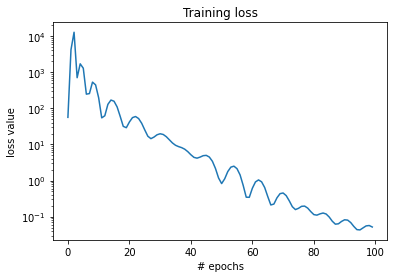

In [37]:
train_loss = train(100, autoencoder_conv, criterion, optimizer) 

In [38]:
ans = encoder_conv(full_tensor_batch.to(device))

In [39]:
X = ans.cpu().squeeze().detach().numpy()


In [50]:
X_trained = X.reshape(607, 16*1006)

In [51]:
X_trained.shape

(607, 16096)

In [41]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


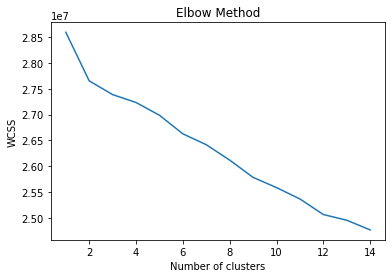

In [52]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_trained)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
purity


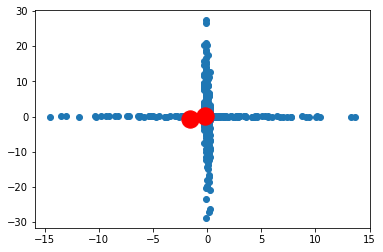

In [58]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_trained)
plt.scatter(X[7, :], X[1,:])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
# plt.show()

In [ ]:
events_clusters = dict() #initial clusters dict. key - cluster defining triplet, value - list of sequences
events_triplets = dict() # key -sequence, value -list of clusters

In [ ]:
for i in range(len(grid)):
  for k in range(n):
    T_j = grid[i]
    Delta_T = np.linspace(0, grid[i], 2**k)
    Delta_T = Delta_T[Delta_T< int(T_j)]
    Delta_T = tuple(Delta_T)
    for p_k in events:
     
      triplet = (int(T_j), Delta_T, fws_array(p_k, Delta_T))
      
      if triplet not in events_clusters.keys():
        events_clusters[triplet] = []
        events_clusters[triplet].append(p_k) 
      else:
        events_clusters[triplet].append(p_k) 
      p_k1 = tuple(p_k)
      if p_k1 not in events_triplets.keys():
        events_triplets[p_k1] = []
        events_triplets[p_k1].append(triplet)
      else:
        events_triplets[p_k1].append(triplet)

In [ ]:
#dropping clusters with less then N sequences in it
optimal_clusters = {}
for k,v in events_clusters.items():
  if len(v)>= N:
    optimal_clusters[k] = v

In [ ]:
arr = list(optimal_clusters.keys())

In [ ]:
arr2 = np.array(arr)

In [ ]:
arr2

In [ ]:

ssn, Tsn, class2idxn, user_listn = load_data(path, 40, 41, maxlen=200)



In [ ]:
p_new = sep_hawkes_proc(user_listn,9)[0]

In [ ]:
p_new

In [ ]:
# A = 'polynomial' #input()
# B = 'exponential' #input()
# d = [[2147483646 for j in range(len(A)+1)]for i in range(len(B)+1)]
# for i in range(len(A)+1):
#     for j in range(len(B)+1):
#         d[i][j].append(2147483646)
  
  

def diffLit(s,t):
    return int(s != t)



def EditDIstTD(i,j):
    sub,deel, ins = 0,0,0
    el =0
    if d[i][j] == 2147483646:
        if i == 0:
            d[i][j] = j
        elif j == 0:
            d[i][j]= i
        else:
            ins = EditDIstTD(i, j-1)+1
            deel = EditDIstTD(i-1, j)+1
            sub = EditDIstTD(i-1, j-1) + diffLit(A[j-1], B[i-1])
            d[i][j] = min(ins, deel, sub)

    return d[i][j]


def Levenshtein(A, B):
  for i in range(1,len(B)+1):
      for j in range(1, len(A)+1):
          EditDIstTD(i,j)
  return d[-1][-1]



# print(d[-1][-1])

In [ ]:
len(list(events_clusters.keys()))

In [ ]:
for k in events_clusters.keys():
  if k[0] ==3:
    print(k)

In [ ]:
treshold = 0.5

In [ ]:
#computing triplets for a new sequence
t =3
grid_cut = grid[grid<t]
p_new_triplets = []
n = 5
for k in range(n):
    Delta_T = np.linspace(0, grid_cut[-1], 2**k)
    Delta_T = tuple(Delta_T)
    triplet = (int(t), Delta_T, fws_array(p_new, Delta_T))

    if triplet not in p_new_triplets:
      p_new_triplets.append(triplet)

In [ ]:
for triplet in p_new_triplets:
  if triplet in optimal_clusters.keys():
    print('found cluster ', triplet) #we have the exact match in triplets buncg
  elif triplet not in optimal_clusters.keys():
    optimal_array = np.array(list(optimal_clusters.keys()))
    triplet_array = np.array(triplet)
    #loook for triplets that have thr same time Tj and time partition
    triplets_to_check = optimal_array[list(map(bool, np.prod(optimal_array[:,:-1] ==triplet_array[:-1], axis =1)))]

    for trips in triplets_to_check:
      A = trips[2]
      B = triplet[2]
      d = [[2147483646 for j in range(len(A)+1)]for i in range(len(B)+1)]
      if len(A) != len(B):
        print('here')
        if (A in B) or (B in A):
          print('found subcluster' , trips)
        else:
          if Levenshtein(A,B)/ max(len(A), len(B)) < treshold:
            print('found closest cluster', trips)
          else:
            print('no closests cluster for ', triplet)
      elif len(A) == len(B):
        if Levenshtein(A,B)/len(B) < treshold:
          print('found closest cluster', trips)
        else:
          print('no closests cluster for ', triplet)

    # ind = 0
    # for i in range(len(triplet[2])):
    #   new_fws = triplet[2][:-i]
    #   new_triplet = (triplet[0], triplet[1], new_fws)
    #   if new_triplet in optimal_clusters.keys():
    #     ind = 1
    #     print('found cluster ', new_triplet)
    #   if ((new_fws =='')and(ind ==0)):
    #       print('no closests cluster for ', triplet)

In [ ]:
hawkes_process_wo_event_types(ss)

In [ ]:
run_time = 40

hawkes = SimuHawkes(n_nodes=1, end_time=run_time, verbose=False, seed=1398)
kernel = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
hawkes.set_kernel(0, 0, kernel)
hawkes.set_baseline(0, 1.)

dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()
timestamps2 = hawkes.timestamps

In [ ]:
for i in range(len(grid)):
  for k in range(n):
    Delta_T = np.arange(0, grid[i], 2**k)
    Delta_T = tuple(Delta_T)
    for p_k in events:
      T_j = grid[i]
      triplet = (int(T_j), Delta_T, fws_array(p_k, Delta_T))
      
      if triplet not in events_clusters.keys():
        events_clusters[triplet] = []
        events_clusters[triplet].append(p_k) 
      else:
        events_clusters[triplet].append(p_k) 
      p_k1 = tuple(p_k)
      if p_k1 not in events_triplets.keys():
        events_triplets[p_k1] = []
        events_triplets[p_k1].append(triplet)
      else:
        events_triplets[p_k1].append(triplet)

In [ ]:
N = 7 # optimal clusters

In [ ]:
optimal_clusters = {}
for k,v in events_clusters.items():
  if len(v)>= N:
    optimal_clusters[k] = v

In [ ]:
optimal_clusters.values.val

In [ ]:
p_new = timestamps2[0]

In [ ]:
Tsn[0].item()

In [ ]:
# t = Tsn[0].item()
 #current_time


In [ ]:
for triplet in p_new_triplets:
  if triplet in optimal_clusters.keys():
    print('found cluster ', triplet)
  if triplet not in optimal_clusters.keys():
    ind = 0
    for i in range(len(triplet[2])):
      new_fws = triplet[2][:-i]
      new_triplet = (triplet[0], triplet[1], new_fws)
      if new_triplet in optimal_clusters.keys():
        ind = 1
        print('found cluster ', new_triplet)
      if ((new_fws =='')and(ind ==0)):
          print('no closests cluster for ', triplet)

3 - non trivial


13 -non trivial

15 - non trivial

for 0 

5 - non trivial for 12

In [ ]:
p_new_triplets